<a href="https://colab.research.google.com/github/alitariq1/vol-protected-ts-momentum/blob/main/vol_protected_ts_momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We use the `yfinance` package to download daily historical SPY data from 2015 to 2024. We extract the closing prices for signal generation and return calculation.

/tmp/ipython-input-3-1829401402.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2015-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'SPY Close Prices'}, xlabel='Date'>

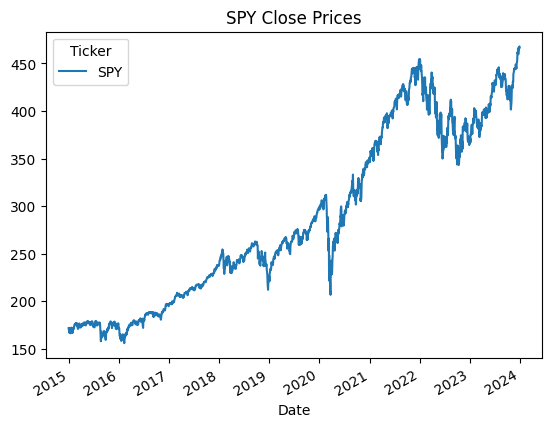

In [3]:
data = yf.download("SPY", start="2015-01-01", end="2024-01-01")
prices = data['Close']
prices.plot(title="SPY Close Prices")

We compute a 60-day time-series momentum by calculating the percentage change from 60 trading days ago. If the return is positive, the strategy takes a long position (signal = 1). If not, it stays in cash (signal = 0). This forms a binary momentum signal.

In [4]:
lookback = 60  # days
momentum = prices.pct_change(lookback)  # % return over 60 days
signal = (momentum > 0).astype(int)  # 1 = buy, 0 = cash

To reduce risk exposure during volatile periods, we calculate a 20-day rolling standard deviation of daily returns to estimate volatility. We then determine the 80th percentile of this volatility series as a threshold. A volatility filter is applied: if the current volatility is below the threshold, the filter is active (1), otherwise inactive (0).


In [5]:
vol = prices.pct_change().rolling(20).std()  # 20-day rolling volatility
vol_threshold = vol.quantile(0.8)
vol_filter = (vol < vol_threshold).astype(int)

The final trading signal is the product of the momentum signal and the volatility filter. This ensures the strategy only takes trades when both the momentum condition is met and volatility is low.


In [6]:
final_signal = signal * vol_filter

We calculate the daily returns of SPY and multiply them by the lagged final signal (shifted by one day) to avoid lookahead bias. This simulates taking action based on yesterday’s signal.


In [7]:
daily_returns = prices.pct_change()
strategy_returns = final_signal.shift(1) * daily_returns  # shift avoids lookahead

We compute cumulative returns by compounding the daily strategy returns. We also calculate the annualized Sharpe ratio to evaluate the risk-adjusted performance of the strategy.


<Axes: title={'center': 'Strategy Cumulative Returns'}, xlabel='Date'>

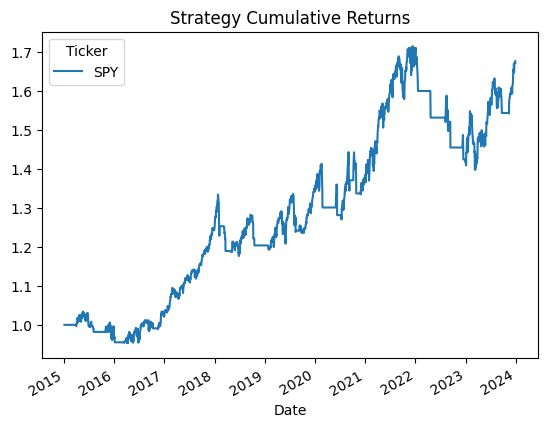

In [8]:
cumulative = (strategy_returns + 1).cumprod()
cumulative.plot(title="Strategy Cumulative Returns")

In [10]:
strategy_returns = strategy_returns.squeeze()  # makes it Series if only 1 column
sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

print("Sharpe Ratio:", sharpe)

Sharpe Ratio: 0.6243589714104056
